### Time Series Forecasting using LSTM and GRU
In this notebook will use LSTM & GRU for predicting the price of stocks of Google for the year 2017

## Importing the libraries

In [24]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import tensorflow as tf

## Helper Functions for Plotting Predictions and Calculating RMSE

In [25]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Google Stock Price')
    plt.plot(predicted, color='blue',label='Predicted Google Stock Price')
    plt.title('Google Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Google Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

## Getting the data

In [26]:
# First, we get the data
dataset = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


Slpitting dataset to train set (Before 2017) and test set (2017 and beyond)

In [27]:
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

Visualizing the data

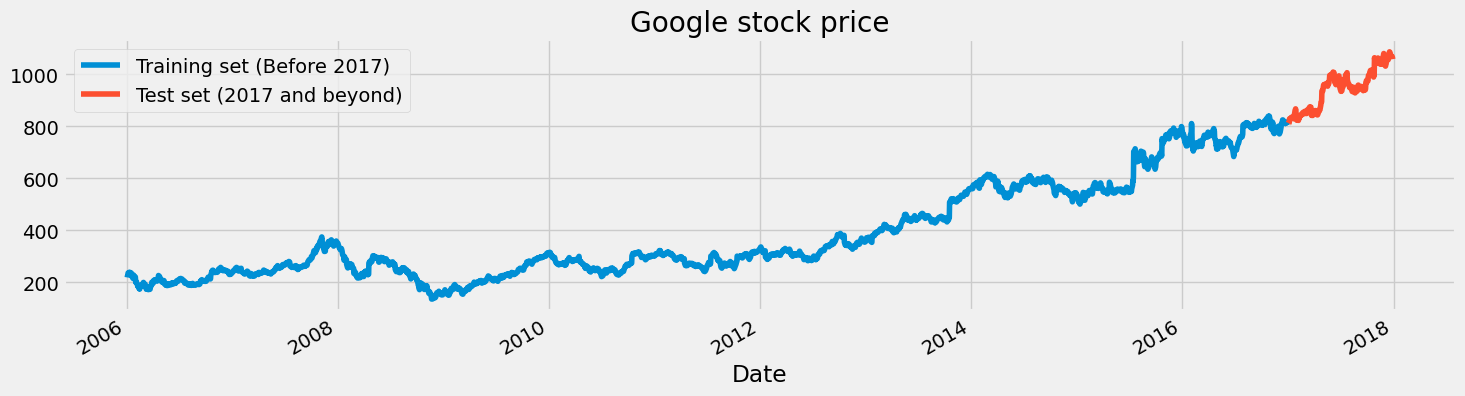

In [28]:
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('Google stock price')
plt.show()

## Data Preprocessing

Scaling the training set

In [29]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output. So for each element of training set, we have 60 previous training set elements

In [30]:
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i-1,0])
X_train, y_train = np.array(X_train), np.array(y_train)

Reshaping X_train for efficient modelling

In [31]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

## LSTM Model

In [32]:
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))

regressor.compile(optimizer='rmsprop',loss='mean_squared_error')

regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 7s 14ms/step - loss: 0.0118
Epoch 2/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0062
Epoch 3/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0050
Epoch 4/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0042
Epoch 5/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0036
Epoch 6/50
85/85 [==============================] - 1s 16ms/step - loss: 0.0033
Epoch 7/50
85/85 [==============================] - 2s 18ms/step - loss: 0.0031
Epoch 8/50
85/85 [==============================] - 1s 16ms/step - loss: 0.0031
Epoch 9/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0028
Epoch 10/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0026
Epoch 11/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0023
Epoch 12/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0023
Epoch 13/50
85/85 [==================


## Make preductuion with LSTM model

In [33]:
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [34]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 [==============================] - 2s 9ms/step


Visualizing the results

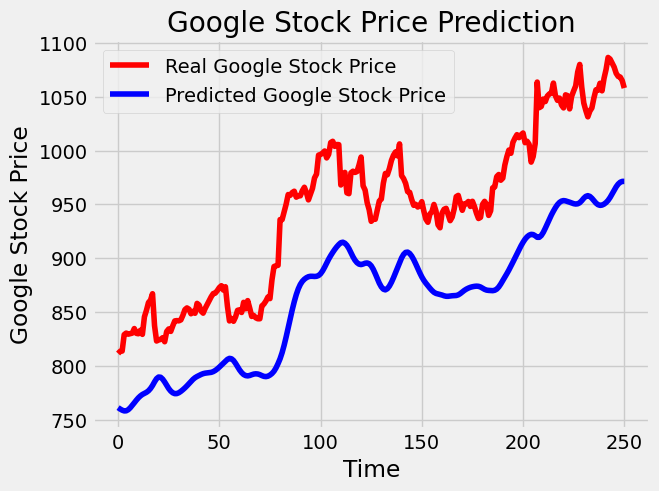

In [35]:
plot_predictions(test_set,predicted_stock_price)

Evaluating LSMT Model

In [36]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 84.60439269941719.


## GRU Model

In [37]:
regressorGRU = Sequential()
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(Dense(units=1))

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9
)
regressorGRU.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=False),loss='mean_squared_error')


regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
19/19 [==============================] - 5s 18ms/step - loss: 0.1044
Epoch 2/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0368
Epoch 3/50
19/19 [==============================] - 0s 12ms/step - loss: 0.0088
Epoch 4/50
19/19 [==============================] - 0s 12ms/step - loss: 0.0039
Epoch 5/50
19/19 [==============================] - 0s 12ms/step - loss: 0.0031
Epoch 6/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0028
Epoch 7/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0025
Epoch 8/50
19/19 [==============================] - 0s 12ms/step - loss: 0.0026
Epoch 9/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0023
Epoch 10/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0024
Epoch 11/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0021
Epoch 12/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0024
Epoch 13/50
19/19 [==================


## Make preductuion with GRU model

In [38]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

8/8 [==============================] - 1s 7ms/step


Visualizing the Results

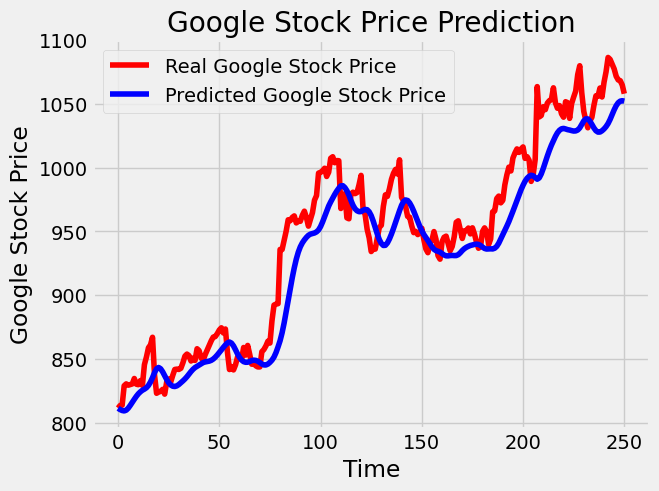

In [39]:
plot_predictions(test_set,GRU_predicted_stock_price)

Evaluating GRU Model

In [40]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 24.994026746927815.
